## 7. Implement boosting and bagging with your choice of base models and explain all the steps 20

<p style="color:green;">Bagging is training multiple models (base learners) on different random subsets of the training data (with replacement). After training, the predictions of the individual models are averaged (for regression) or voted on (for classification) to get the final prediction.
</p>
<p style="color:green;"> Boosting is an ensemble technique where models (base learners) are trained sequentially. Each subsequent model attempts to correct the mistakes made by the previous models. It focuses on the harder examples that the earlier models misclassified.</p>

The text below can be added to the report md file:

We have implemented two ensemble learning methods, **Bagging** and **Boosting**.\
The **Bagging model** employs a `RandomForestClassifier` as its base estimator within a `BaggingClassifier`, where multiple decision trees are trained independently on random subsets of both samples and features.\
This parallel training reduces variance, prevents overfitting and improves model stability.\
The **Boosting model**, based on `XGBClassifier`, builds an ensemble of weak learners sequentially, where each new tree focuses on correcting the misclassifications made by previous ones.\
This reduced bias and improves predictive performance.

**Modified pipeline**\
The data is first split into training and testing sets using stratified sampling to preserve class distribution. Missing values are handled using a `SimpleImputer` with a median strategy.\
Next, a **`GridSearchCV`** is applied for hyperparameter tuning, testing combinations of parameters like the number of estimators, tree depth, learning rate, and subsampling ratios over multiple cross-validation folds.\
Finally, the best-performing model is refit on the training set and evaluated on the test data using accuracy metrics.\
Although computationally intensive, this approach provides a reliable comparison between Bagging and Boosting techniques.

<h3 style="color:red"> WARNING: THE CODE BELOW TAKES A LONG TIME TO RUN</h3>

In [2]:
### Modified Pipeline ### SLOW VERSION

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df = pd.read_csv("./student-graduation/processed/test.csv")
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target'])

# Function to return model and param_grid
def get_model_and_params(model_type):
    model_type = str(model_type).strip().lower()

    if model_type == "random_forest":
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        param_grid = {
            'model__n_estimators': [100, 300],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
    elif model_type == "svm":
        model = SVC(random_state=42)
        param_grid = {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        }
    elif model_type == "xgboost":
        model = XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1)
        param_grid = {
            'model__n_estimators': [100, 300],
            'model__max_depth': [3, 6],
            'model__learning_rate': [0.01, 0.1]
        }
    elif model_type == "bagging":
        base_model = RandomForestClassifier(random_state=42)  # Base model for bagging
        model = BaggingClassifier(base_model, random_state=42, n_jobs=-1)
        param_grid = {
            'model__n_estimators': [50, 100, 300],
            'model__max_samples': [0.5, 0.8, 1.0],
            'model__max_features': [0.5, 0.8, 1.0]
        }
    elif model_type == "boosting":
        model = XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1)
        param_grid = {
            'model__n_estimators': [100, 300],
            'model__max_depth': [3, 6],
            'model__learning_rate': [0.01, 0.1],
            'model__subsample': [0.8, 1.0]
        }
    else:
        raise ValueError("Unknown model type")
    
    return model, param_grid

def run_pipeline(data: pd.DataFrame, target_column: str, model_type: str):
    if target_column not in data.columns:
        raise ValueError(f"Target column '{target_column}' not found in the data.")

    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Conservative CV based on smallest class frequency
    min_class_count = pd.Series(y).value_counts().min()
    cv = int(min(5, max(2, min_class_count)))

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    model, param_grid = get_model_and_params(model_type)

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Handling missing values
        ('model', model)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        refit=True,
        error_score='raise'
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"✅ Best parameters: {grid_search.best_params_}")
    print(f"📊 Test accuracy: {acc}")
    return best_model

# Running Bagging (Random Forest) model
bagging_model = run_pipeline(df, target_column='Target', model_type='bagging')

# Running Boosting (XGBoost) model
boosting_model = run_pipeline(df, target_column='Target', model_type='boosting')

✅ Best parameters: {'model__max_features': 0.8, 'model__max_samples': 1.0, 'model__n_estimators': 50}
📊 Test accuracy: 0.7837837837837838
✅ Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__subsample': 0.8}
📊 Test accuracy: 0.7747747747747747


In [14]:
### FAST VERSION ###
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load data
df = pd.read_csv("./student-graduation/processed/test.csv")
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target'])

def get_model_and_params_fast(model_type):
    model_type = str(model_type).strip().lower()

    if model_type == "bagging":
        base = RandomForestClassifier(random_state=42, n_jobs=-1)
        model = BaggingClassifier(base, random_state=42, n_jobs=-1)
        param_grid = {
            'model__n_estimators': [50],
            'model__max_samples': [0.8],
            'model__max_features': [0.8]
        }
    elif model_type == "boosting":
        model = XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1)
        param_grid = {
            'model__n_estimators': [50],
            'model__max_depth': [3],
            'model__learning_rate': [0.1],
            'model__subsample': [1.0]
        }
    else:
        raise ValueError("Only 'bagging' or 'boosting' supported for fast run.")
    
    return model, param_grid

def run_pipeline_fast(data, target_column, model_type):
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Optional: subsample data
    if len(X) > 1500:
        X, y = X.sample(1500, random_state=42), y.sample(1500, random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    model, param_grid = get_model_and_params_fast(model_type)

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', model)
    ])

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=1,     # just 1 configuration
        cv=2,         # only 2 folds
        n_jobs=-1,
        scoring='accuracy',
        refit=True,
        random_state=42
    )

    search.fit(X_train, y_train)
    y_pred = search.best_estimator_.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"✅ Best params: {search.best_params_}")
    print(f"📊 Test accuracy: {acc:.3f}")
    return search.best_estimator_

# Run both fast versions
bagging_model = run_pipeline_fast(df, target_column='Target', model_type='bagging')
boosting_model = run_pipeline_fast(df, target_column='Target', model_type='boosting')


✅ Best params: {'model__n_estimators': 50, 'model__max_samples': 0.8, 'model__max_features': 0.8}
📊 Test accuracy: 0.689
✅ Best params: {'model__subsample': 1.0, 'model__n_estimators': 50, 'model__max_depth': 3, 'model__learning_rate': 0.1}
📊 Test accuracy: 0.698


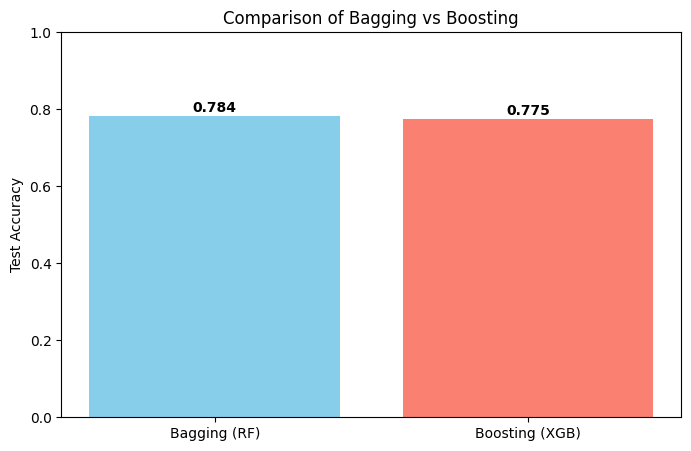

In [4]:
import matplotlib.pyplot as plt

# Store accuracies manually from pipeline
acc_bagging_fast = 0.7837837837837838 # replace as needed
acc_boosting_fast = 0.7747747747747747 # replace as needed

models = ['Bagging (RF)', 'Boosting (XGB)']
accuracies = [acc_bagging_fast, acc_boosting_fast]

plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Comparison of Bagging vs Boosting")
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()

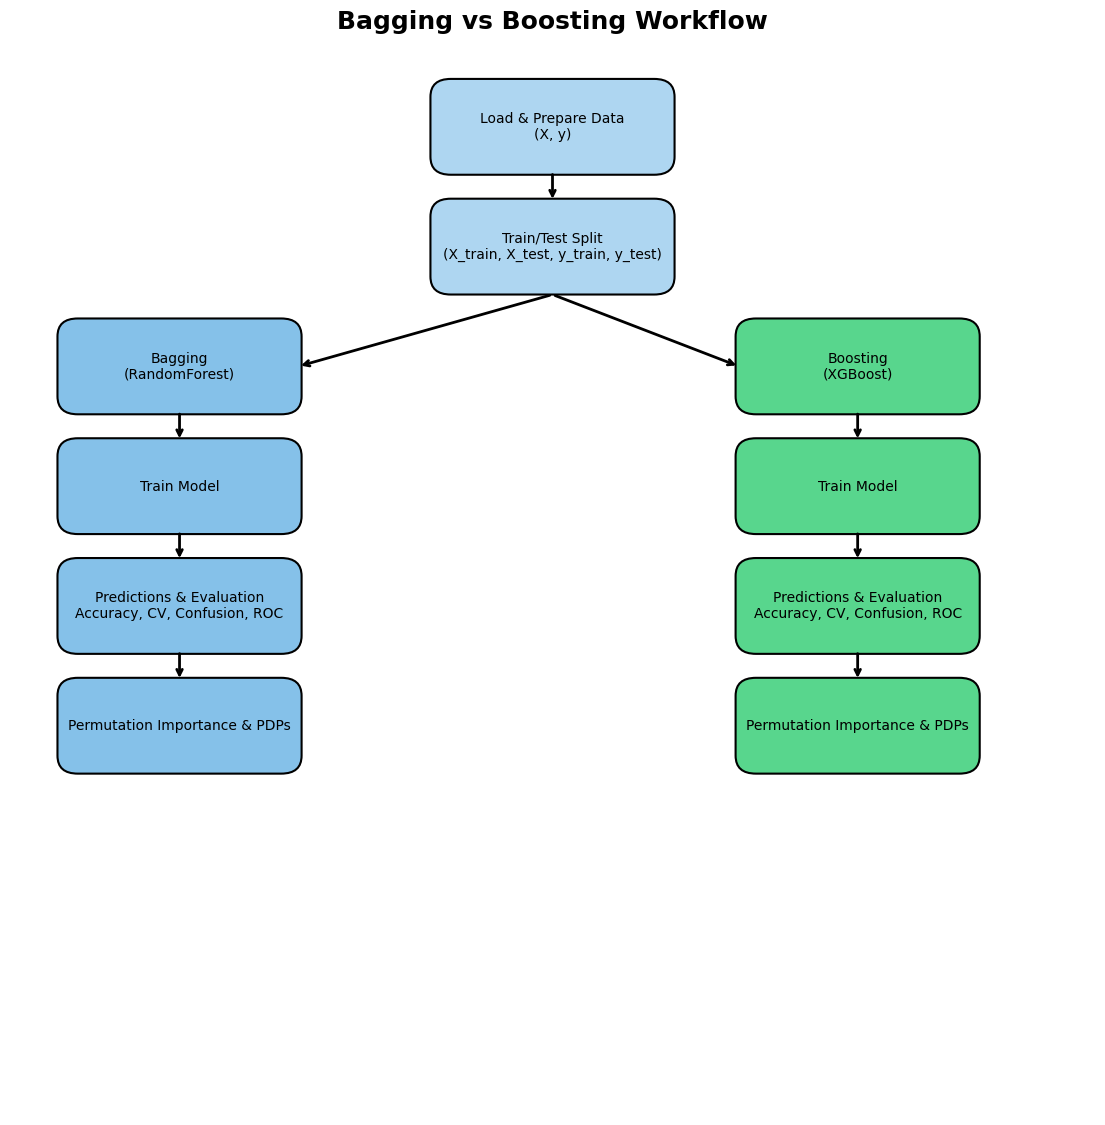

In [5]:
### EXPLANATION DIAGRAM ###
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(figsize=(14, 14))
ax.axis('off')

def draw_box(text, xy, width=3, height=1, color='#AED6F1'):
    box = FancyBboxPatch(
        xy, width, height,
        boxstyle="round,pad=0.3",
        edgecolor='black',
        facecolor=color,
        linewidth=1.5
    )
    ax.add_patch(box)
    ax.text(xy[0]+width/2, xy[1]+height/2, text, ha='center', va='center', fontsize=10)

# Set plot limits
ax.set_xlim(0, 16)
ax.set_ylim(0, 18)

# Central Data boxes (top)
draw_box("Load & Prepare Data\n(X, y)", (6.5, 16))
draw_box("Train/Test Split\n(X_train, X_test, y_train, y_test)", (6.5, 14))

# Bagging branch (left) - blue
bag_color = '#85C1E9'
draw_box("Bagging\n(RandomForest)", (1, 12), color=bag_color)
draw_box("Train Model", (1, 10), color=bag_color)
draw_box("Predictions & Evaluation\nAccuracy, CV, Confusion, ROC", (1, 8), color=bag_color)
draw_box("Permutation Importance & PDPs", (1, 6), color=bag_color)

# Boosting branch (right) - green
boost_color = '#58D68D'
draw_box("Boosting\n(XGBoost)", (11, 12), color=boost_color)
draw_box("Train Model", (11, 10), color=boost_color)
draw_box("Predictions & Evaluation\nAccuracy, CV, Confusion, ROC", (11, 8), color=boost_color)
draw_box("Permutation Importance & PDPs", (11, 6), color=boost_color)

# Draw arrows
def draw_arrow(start, end):
    ax.annotate('', xy=end, xytext=start,
                arrowprops=dict(arrowstyle='->', lw=2))

# Central flow arrows
draw_arrow((8, 15.75), (8, 15.25))      # Data -> Split
draw_arrow((8, 13.7), (4.25, 12.5))    # Split -> Bagging
draw_arrow((8, 13.7), (10.75, 12.5))   # Split -> Boosting

# Bagging arrows
draw_arrow((2.5, 11.75), (2.5, 11.25))
draw_arrow((2.5, 9.75), (2.5, 9.25))
draw_arrow((2.5, 7.75), (2.5, 7.25))

# Boosting arrows
draw_arrow((12.5, 11.75), (12.5, 11.25))
draw_arrow((12.5, 9.75), (12.5, 9.25))
draw_arrow((12.5, 7.75), (12.5, 7.25))

plt.title("Bagging vs Boosting Workflow", fontsize=18, fontweight='bold')
plt.show()
